<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2023TeamB/blob/main/source_covid19_ANTICOVIS_DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Erstellung der SQL-Quelldatenbank des ANTICOVIS-Projekts

---
##Einleitung
---


Dieses Colab-Books soll der Erstellung einer Datenbank dienen, in die die Daten des Covid19 Datensets geladen werden. Zudem werden hier staging tabellen erstellt aus denne die Faktentabelle und die dimmensionstabellen im Datenwarehoaus gefüllt werden. Auch soll die Datenbank dann als Grundlage für weitere Analysen im Rahmen des Projekts dienen.

Quelldatenset: Synthea Covid19 https://github.com/Fuenfgeld/DMA2023TeamB/tree/main/CSV_Data

Primär- und Fremdschlüsselbedingungen werden entnommen aus dem Synthea Repositorium: https://github.com/synthetichealth/synthea/wiki/CSV-File-Data-Dictionary


---
Quelldatenordner klonen und benötigte python Module laden
---


Quelldatenordner von Synthea in "https://github.com/Fuenfgeld/DatamanagementAndArchiving" zu eigenen Dateiordnern klonen, um Zugriff auf die Synthea CSV-Dateien aller Erkrankungen zu erlangen.

Die Covid19-CSV-Dateien sind zudem separat im ANTICOVIS-Repositorium hinterlegt: https://github.com/Fuenfgeld/DMA2023TeamB/tree/main/CSV_Data

In [1]:
import pandas as pd
from functools import reduce
import sqlite3
from sqlite3 import Error
import csv

###Angaben zur systemumgebung und den verweendeten python Module

---



In [2]:
# Python-Version
print("Python-Version:")
!python --version

# Pandas-Version
print("\n" + "Pandas-Version:")
print(pd.__version__)

# sqlite3-Version
print("\n" + "sqlite3-Version:")
sqlite3.sqlite_version

Python-Version:
Python 3.8.10

Pandas-Version:
1.3.5

sqlite3-Version:


'3.31.1'

#Vorbereitung
Montieren des google Drive

überprüfund des vorhandensein der CSV Dateinen

Festlegen des Pfad zu den Quelldaten. Für unser Projekt werden ledeglisch die Daten der COVID-19 Erkrankten patienten benötigt.

Festlegen des Pfad zum ablageort der in diesem skript erzeugten Datenbank.

In [3]:
# montieren von google drive mit Shareddrive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# überprüfend des vorhandensein des Datenbankordner auf Shareddrive
!ls "/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldatenbank"

source_covid19_ANTIVOVIS_db.db


In [5]:
# überprüfen der Quelldatenordner
!ls "/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten"

allergy  breast_cancer	    covid19	lung_cancer
asthma	 colorectal_cancer  dermatitis	metabolic_syndrome_disease


In [6]:
# Pfad zum speicher ort der Datenbank definieren
DB_FILE_PATH = "/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldatenbank/source_covid19_ANTIVOVIS_db.db"

# Pfad zu CSV Dateien definieren
csv_path = "/content/drive/Shareddrives/DMA_2023_D/DMA2023TeamB/Quelldaten/covid19/"

##ER-Modell aller Quelldaten


---


Die Beziehungen der Tabellen der gesamten Quelldaten von Covid19 untereinander kann folgender Illustration des ER-Modells entnommen werden. Im untenstehenden ER-Modell ist die Datentyp-Beschreibung von Synthea dargestellt.




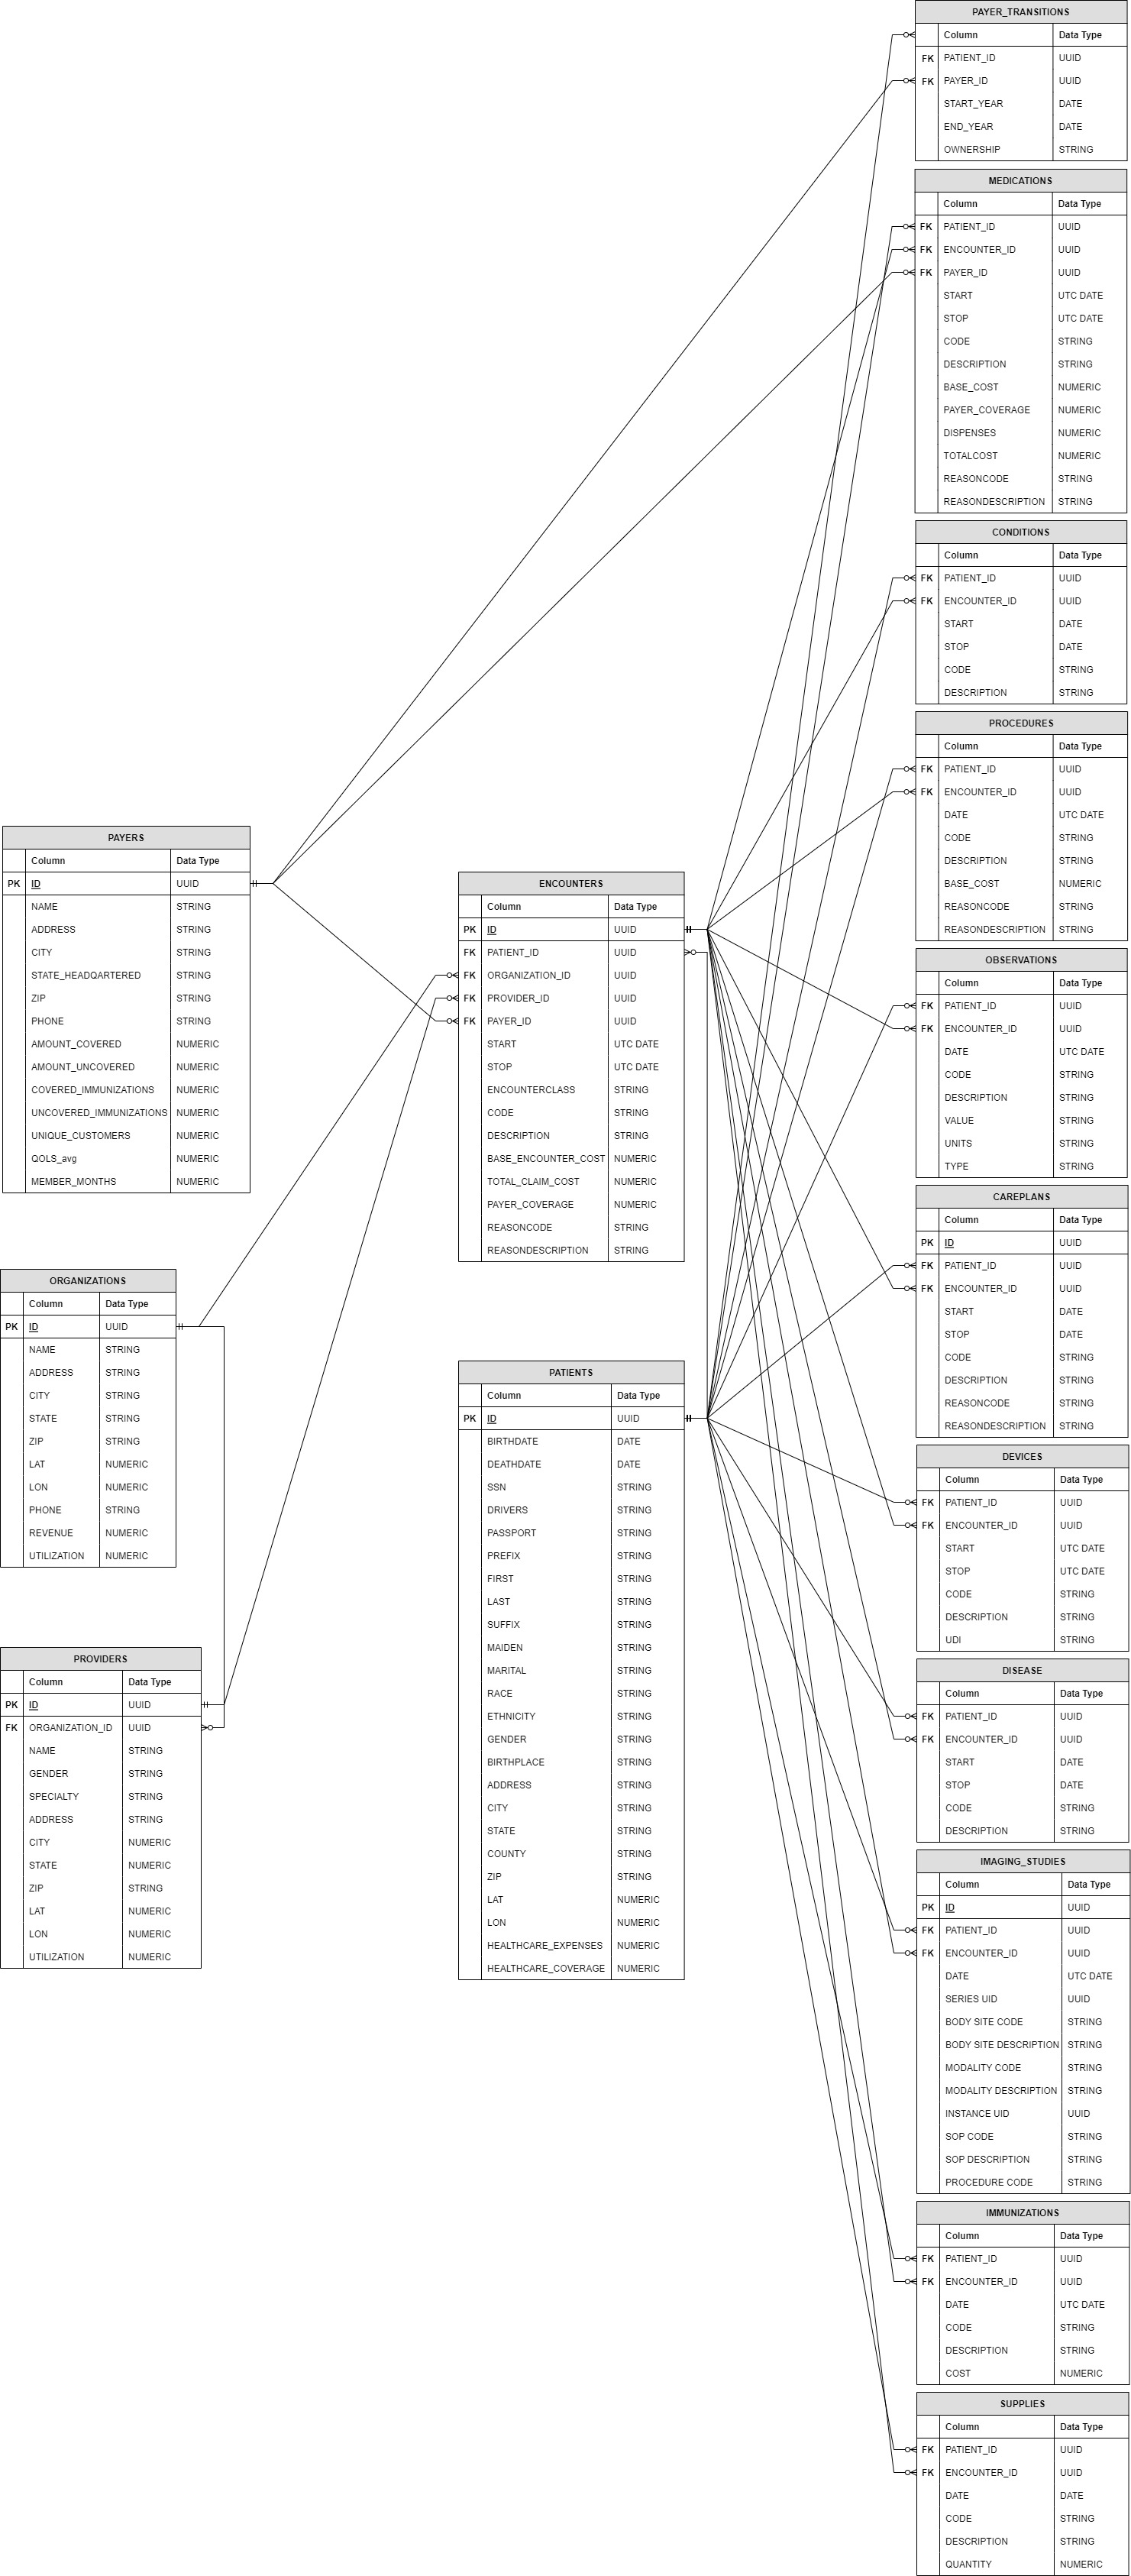

Datenbank Tabellen anlegen

---

Mittels Create Table-Anweisungen werden zunächst alle Datenbank-Tabellen erstellt die für das projekt notwendig sind. Nachfolgeend werden die benötigtedn datene aus den CSV datein ausgelesen und in die datenbanktabellen eingeschrieben.

Die Tabellenkonfiguration (Spalten, Datentypen) sowie Schlüsselbedingungen basieren, wie oben genannt, auf der Synthea-eigenen Datenset-Dokumentation (https://github.com/synthetichealth/synthea/wiki/CSV-File-Data-Dictionary).

Nach Sichten der Quelldaten werden nur solche Tabellen erzeugt, die für die weitere Bearbeitung und Analyse des Projekts benötigt werden. Somit erfolgt keine Create Table-Anweisung für Tabellen, die im Covid19-Datensatz leer sind (disease, imaging_studies) oder nicht erforderlich sind (careplans, observations, payer_transitions, payers, providers, supplies, encounters, immunizations).


---



##Definition der benötigten Funktionen zur: 

*   Herstellung einer Verbindung zur später erzeugten Datenbank
*   Auslesen der CSV Datein und einführen der Daten in die Datenbanktabellen
*   CSV-Datei im Reading-Modus öffnen und als csv_file speichern und Liste aus den Daten erstellen.
*   Die Spaltennamen aus einer Datenbanktabelle in eine Liste umwandeln und in eine durch Komma getrennte Zeichenkette umwandeln 

In [7]:
# Verbindung zu Datenbank setzen
def connect_to_db(db_file):
    """
    Connect to an SQlite database, if db file does not exist it will be created
    :param db_file: absolute or relative path of db file
    :return: sqlite3 connection
    """
    sqlite3_conn = None

    try:
        sqlite3_conn = sqlite3.connect(db_file)
        return sqlite3_conn

    except Error as err:
        print(err)

        if sqlite3_conn is not None:
            sqlite3_conn.close()

# CSV Daten einlesen und diese in entsprechende Tabelle in Datenbank einfügen
def insert_values_to_table(cursor, table_name, csv_file_path):

    """
    Open a csv file, store its content in a list excluding header and insert the data from the list to db table
    :param table_name: table name in the database to insert the data into
    :param csv_file_path: path of the csv file to process
    :returns SQL insert process finished if successful else no CSV-Data available
    """

    # Einlesen
    values_to_insert = open_csv_file(csv_file_path)

    # Einfügen in Tabellen
    if len(values_to_insert) > 0:
        column_names, column_numbers = get_column_names_from_db_table(cursor, table_name)
        values_str = '?,' * column_numbers
        values_str = values_str[:-1]
        sql_query = 'INSERT OR REPLACE INTO ' + table_name + '(' + column_names + ') VALUES (' + values_str + ')'
        cursor.executemany(sql_query, values_to_insert)
        print('SQL insert process finished')
    else:
       print('no CSV-Data available')


# CSV-Datei im Reading-Modus öffnen und als csv_file speichern, Liste aus den Daten erstellen.
def open_csv_file(csv_file_path):
    """
    Open and read data from a csv file without headers (skipping the first row)
    :param csv_file_path: path of the csv file to process
    :return: a list with the csv content
    """
    with open(csv_file_path, 'r', encoding='utf-8') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)

        data = list()
        for row in reader:
            data.append(row)

        return data

# Die Spaltennamen aus einer Datenbanktabelle in eine Liste umwandeln und in eine durch Komma getrennte Zeichenkette umwandeln.
# Erstellen eines SQL-Cursors, der auf Datenbank verweist und aufgerufen wird.
def get_column_names_from_db_table(sql_cursor, table_name):

    """
    Scrape the column names from a database table to a list and convert to a comma separated string, count the number
    of columns in a database table
    :param sql_cursor: sqlite cursor
    :param table_name: table name to get the column names from
    :return: a comma separated string with column names, an integer with number of columns
    """

    table_column_names = 'PRAGMA table_info(' + table_name + ');'
    sql_cursor.execute(table_column_names)
    table_column_names = sql_cursor.fetchall()

    column_count = len(table_column_names)

    column_names = list()

    for name in table_column_names:
        column_names.append(name[1])

    return ', '.join(column_names), column_count

#Erzeugen und befüllen von den datenbanktabellen



##CREATE TABLE queries und sommitt definition der zu erzeugenden Tabellen

In [8]:
# dictionary key: name of table, values: sql query to create table
sql_table = {}

# SQL-Anweisung zur Erstellung der Tabelle "conditions"
sql_table["conditions"] = """CREATE TABLE IF NOT EXISTS conditions (
                           START DATE,
                           STOP DATE,
                           PATIENT VARCHAR,
                           ENCOUNTER VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id) 

                       );"""

# SQL-Anweisung zur Erstellung der Tabelle "devices"
sql_table["devices"] = """CREATE TABLE IF NOT EXISTS devices (
                           START DATETIME,
                           STOP DATETIME,
                           PATIENT VARCHAR,
                           ENCOUNTER VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           UDI VARCHAR,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id)
                           
                       );"""

# SQL-Anweisung zur Erstellung der Tabelle "medications"
sql_table["medications"] = """CREATE TABLE IF NOT EXISTS medications (
                           START DATETIME,
                           STOP DATETIME,
                           PATIENT VARCHAR,
                           PAYER VARCHAR,
                           ENCOUNTER VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           BASE_COST FLOAT,
                           PAYER_COVERAGE FLOAT,
                           DISPENSES INTEGER,
                           TOTALCOST FLOAT,
                           REASONCODE INTEGER,
                           REASONDESCRIPTION VARCHAR,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           
                       );"""



# SQL-Anweisung zur Erstellung der Tabelle "patients"
sql_table["patients"] = """CREATE TABLE IF NOT EXISTS patients (
                           Id VARCHAR PRIMARY KEY,
                           BIRTHDATE DATE,
                           DEATHDATE DATE,
                           SSN VARCHAR,
                           DRIVERS VARCHAR,
                           PASSPORT VARCHAR,
                           PREFIX VARCHAR,
                           FIRST VARCHAR,
                           LAST VARCHAR,
                           SUFFIX VARCHAR,
                           MAIDEN VARCHAR,
                           MARITAL CHAR(1),
                           RACE VARCHAR,
                           ETHNICITY VARCHAR,
                           GENDER CHAR(1),
                           BIRTHPLACE VARCHAR,
                           ADDRESS VARCHAR,
                           CITY VARCHAR,
                           STATE VARCHAR,
                           COUNTRY VARCHAR,
                           ZIP VARCHAR,
                           LAT FLOAT,
                           LON FLOAT,
                           HEALTHCARE_EXPENSES FLOAT,
                           HEALTHCARE_COVERAGE FLOAT
                       );"""


# SQL-Anweisung zur Erstellung der Tabelle "procedures"
sql_table["procedures"]= """CREATE TABLE IF NOT EXISTS procedures (
                           DATE DATETIME,
                           PATIENT VARCHAR,
                           ENCOUNTER VARCHAR,
                           CODE INTEGER,
                           DESCRIPTION VARCHAR,
                           BASE_COST FLOAT,
                           REASONCODE INTEGER,
                           REASONDESCRIPTION VARCHAR,
                           FOREIGN KEY (PATIENT)
                              REFERENCES patients (Id) 
                           FOREIGN KEY (Encounter)
                              REFERENCES encounters (Id) 

                       );"""

###ER-modell 

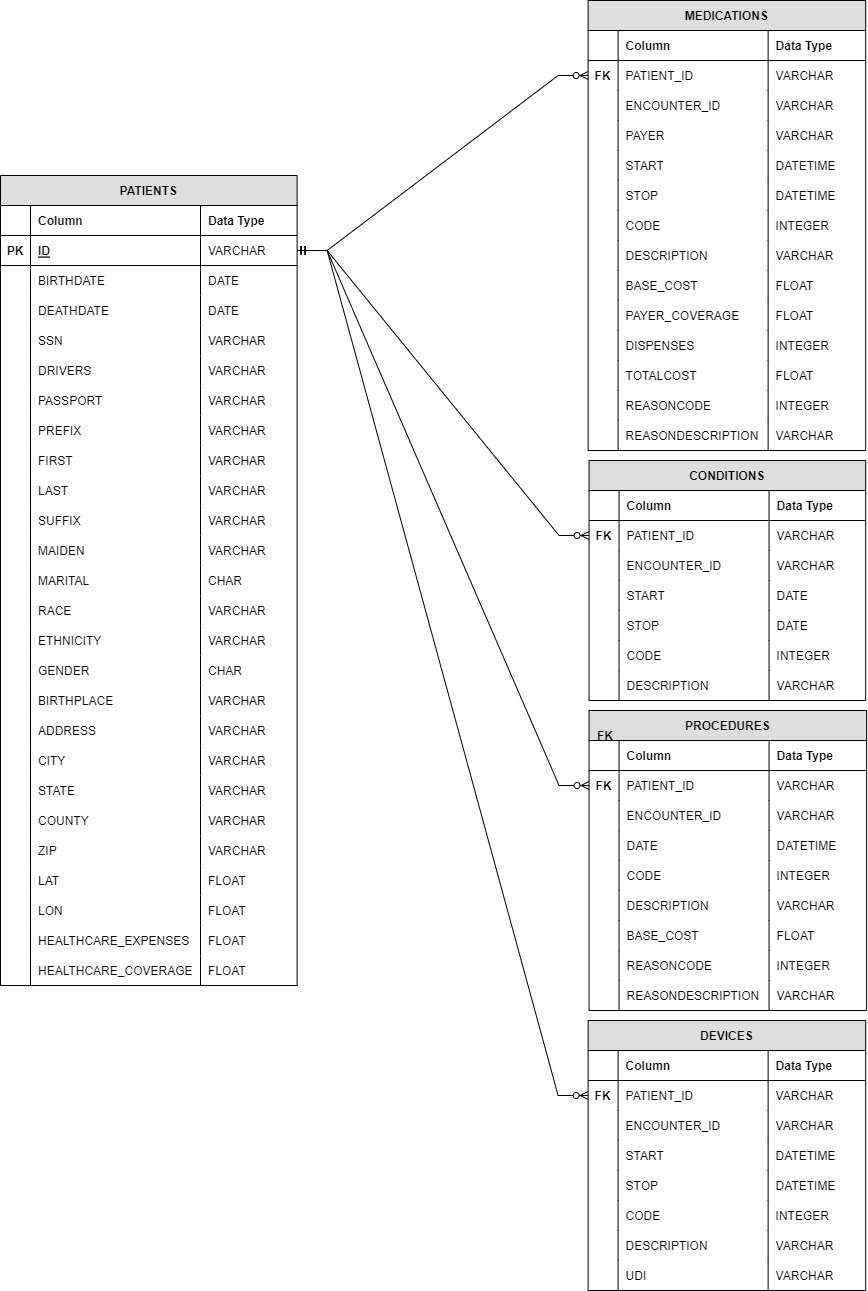

In [9]:
db_file = DB_FILE_PATH

## Datenbanktabeellen erzeugen, CSV-Datein auslesen und Daten in die Datenbanktabellen überführen


Erst wird eine verbindung zur Datenbank ertellt und ein cursor erzeugt der auf die Datenbank zeigt. Sollte dieser prozess schechietern wird 'Connection to database failed' ausgegeben.

Für nun jede zu erzeugende Tabelle wird die entsprechende CSV datei aufgerufen und die Datenbanktabelle erstellt. 

Es wird dann sichergestellt das die zu befüllende tabelle leer ist und nachfolgend werden die daten aus der CSV datei in die entsprechende datenbanktabelle eingeschrieben

Mit der commit methode wird jede Tabelle einzell nach dem befüllen gesichert.

Die verbindung zur Datenbank wird getrennt.

In [10]:
# import csv into db
conn = connect_to_db(DB_FILE_PATH)
if conn is not None:
        cursor = conn.cursor()
        for name in sql_table.keys():
          csv_file = csv_path + name + ".csv"
          cursor.execute(sql_table[name])
          cursor.execute(f"""DELETE FROM {name}""")
          insert_values_to_table(cursor, name, csv_file)
          conn.commit()
else:
        print('Connection to database failed')
conn.close()

SQL insert process finished
SQL insert process finished
SQL insert process finished
SQL insert process finished
SQL insert process finished


#Überprüfen des Innhalt der Tabellen

In [11]:
# get all tables in database
conn = connect_to_db(db_file)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
list_of_tables = cursor.fetchall()

# convert list of tupels to list of str and print list of tables in database wich is also the list of csv data files used
list_of_CSV_Data_Tables =[]
for tupel in list_of_tables:
  if tupel[0][0] == 'S':
    pass
  else:
      list_of_CSV_Data_Tables.append(tupel[0])
print(list_of_CSV_Data_Tables)

# convert CSV files to a dataframe
dataframes_of_CSV_files = []
for table in list_of_CSV_Data_Tables:
  dataframes_of_CSV_files.append(pd.read_csv(f"{csv_path}{table}.csv"))
number_of_rows_in_csv_files = []

# determine number of rowes in CSV files
for dataframe in dataframes_of_CSV_files:
  number_of_rows_in_csv_files.append(len(dataframe.index))
print(number_of_rows_in_csv_files)

# determine number of rows in Database tables
list_of_database_tables = list_of_CSV_Data_Tables
for n in range(0,len(list_of_database_tables)):
  table = list_of_database_tables[n]
  query = f"SELECT count(*) FROM {table}"
  cursor.execute(query)
  number_of_rows_in_database_table = cursor.fetchall()
  if int(number_of_rows_in_database_table[0][0]) == int(number_of_rows_in_csv_files[n]):
    print(f"{list_of_tables[n][0]} tabele in Database has the same number of rows as the corrresponding csv file")
  else:
    print("Fail")

conn.close()

['conditions', 'devices', 'medications', 'patients', 'procedures']
[6375, 165, 890, 1050, 4457]
conditions tabele in Database has the same number of rows as the corrresponding csv file
devices tabele in Database has the same number of rows as the corrresponding csv file
medications tabele in Database has the same number of rows as the corrresponding csv file
patients tabele in Database has the same number of rows as the corrresponding csv file
procedures tabele in Database has the same number of rows as the corrresponding csv file


#Erzeugen und befüllen von staging Tabellen

Es werden nun staging Tabellen erestllt, mit dem prefix 'S',
aus denen die Dimensionsstabellen im Datawarehous später gefüllt werden. Diese tabellen enthalten nun nur die spalten aus den jehweiligen ursprungstabellen die tatsächlisch für die spätere auswertung relevant sind

##CREATE TABLE queries und sommitt definition der zu erzeugenden Tabellen

In [12]:
sql_s_tables = {}

# SQL-Anweisung zur Erstellung der Tabelle "s_conditions"
sql_s_tables ["S_CONDITIONS"] = """CREATE TABLE IF NOT EXISTS S_CONDITIONS (
                            CONDITIONS_CODE STRING PRIMARY KEY,
                            CONDITIONS_DESCRIPTION STRING
                           );"""
# SQL-Anweisung zur Erstellung der Tabelle "s_devices"
sql_s_tables ["S_DEVICES"] = """CREATE TABLE IF NOT EXISTS S_DEVICES (
                            DEVICES_CODE STRING PRIMARY KEY,
                            DEVICES_DESCRIPTION STRING
                           );"""
# SQL-Anweisung zur Erstellung der Tabelle "s_medications"
sql_s_tables ["S_MEDICATIONS"] = """CREATE TABLE IF NOT EXISTS S_MEDICATIONS (
                            MEDICATIONS_CODE STRING PRIMARY KEY,
                            MEDICATIONS_DESCRIPTION STRING
                           );"""
# SQL-Anweisung zur Erstellung der Tabelle "s_procedures"
sql_s_tables ["S_PROCEDURES"]= """CREATE TABLE IF NOT EXISTS S_PROCEDURES (
                            PROCEDURES_CODE STRING PRIMARY KEY,
                            PROCEDURES_DESCRIPTION STRING
                           );"""
# SQL-Anweisung zur Erstellung der Tabelle "s_patients"
sql_s_tables ["S_PATIENTS"] = """CREATE TABLE IF NOT EXISTS S_PATIENTS (
                            PATIENTS_ID STRING PRIMARY KEY,
                            PATIENTS_BIRTHDATE DATE,
                            PATIENTS_DEATHDATE DATE,
                            PATIENTS_GENDER STRING
                           );"""


##Erzeugen der Datafreames zum befüllen der staging tabellen

In [13]:
import sqlite3
from pandas import DataFrame

In [14]:
conn = connect_to_db(DB_FILE_PATH)
if conn is not None:
    cursor = conn.cursor()

    dataframe_dictionary = {}

    # dataframe s_conditions"
    cursor.execute ('SELECT CONDITIONS.CODE, CONDITIONS.DESCRIPTION FROM CONDITIONS')
    DF_S_CONDITIONS = DataFrame(cursor.fetchall())
    DF_S_CONDITIONS.columns = ['CONDITIONS_CODE', 'CONDITIONS_DESCRIPTION']
    dataframe_dictionary["S_CONDITIONS"] = DF_S_CONDITIONS

    # dataframe s_devices"
    cursor.execute ('SELECT DEVICES.CODE, DEVICES.DESCRIPTION FROM DEVICES')
    DF_S_DEVICES = DataFrame(cursor.fetchall())
    DF_S_DEVICES.columns = ['DEVICES_CODE', 'DEVICES_DESCRIPTION']
    dataframe_dictionary["S_DEVICES"] = DF_S_DEVICES

    # dataframe s_medications"
    cursor.execute ('SELECT MEDICATIONS.CODE, MEDICATIONS.DESCRIPTION FROM MEDICATIONS')
    DF_S_MEDICATIONS = DataFrame(cursor.fetchall())
    DF_S_MEDICATIONS.columns = ['MEDICATIONS_CODE', 'MEDICATIONS_DESCRIPTION']
    dataframe_dictionary["S_MEDICATIONS"] = DF_S_MEDICATIONS

    # dataframe s_procedures"
    cursor.execute ('SELECT PROCEDURES.CODE, PROCEDURES.DESCRIPTION FROM PROCEDURES')
    DF_S_PROCEDURES = DataFrame(cursor.fetchall())
    DF_S_PROCEDURES.columns = ['PROCEDURES_CODE', 'PROCEDURES_DESCRIPTION']
    dataframe_dictionary["S_PROCEDURES"] = DF_S_PROCEDURES

    # dataframe s_patients"
    cursor.execute ('SELECT PATIENTS.ID, PATIENTS.BIRTHDATE, PATIENTS.DEATHDATE, PATIENTS.GENDER FROM PATIENTS')
    DF_S_PATIENTS = DataFrame(cursor.fetchall())
    DF_S_PATIENTS.columns = ['PATIENTS_ID', 'PATIENTS_BIRTHDATE', 'PATIENTS_DEATHDATE', 'PATIENTS_GENDER']
    dataframe_dictionary["S_PATIENTS"] = DF_S_PATIENTS

else:
        print('Connection to database failed')
conn.close()

###befüllen der 's' stagingtabellen

In [15]:
conn = connect_to_db(db_file)

if conn is not None:
        cursor = conn.cursor()
        for name in sql_s_tables.keys():
          cursor.execute(sql_s_tables[name])
          cursor.execute(f"""DELETE FROM {name}""")
          corresponding_dataframe = dataframe_dictionary[f"{name}"]
          corresponding_dataframe.to_sql(name ,conn, if_exists = 'replace', index = False)

          conn.commit()
else:
        print('Connection to database failed')
conn.close()

# Test

In [16]:
# conn = sqlite3.connect(DB_FILE_PATH)
# cursor = conn.cursor()
# #cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# cursor.execute("SELECT count(*) FROM s_conditions")
# print(cursor.fetchall())

# Erzeugen und befüllen von staging Tabellen mit einem 'SSS' prefix für das spätere befüllen der Faktentabelle.

Die Faktentabelle im späteren Datenwarehouse wird durch eine Rheie von SQL-Left-joints erzeugt. Um dies zu ermöglischen ist die vergabe von primär und Fremdschlüssel notwendig.

##CREATE TABLE queries und sommitt definition der zu erzeugenden SSS_Tabellen

In [17]:
sql_sss_tables = {}

# SQL-Anweisung zur Erstellung der Tabelle "sss_conditions"
sql_sss_tables ["SSS_CONDITIONS"] = """CREATE TABLE IF NOT EXISTS SSS_CONDITIONS (
                                       CONDITIONS_CODE STRING,
                                       CONDITIONS_DESCRIPTION STRING,
                                       CONDITIONS_PATIENT_ID
                                      );"""

# SQL-Anweisung zur Erstellung der Tabelle "sss_devices"
sql_sss_tables ["SSS_DEVICES"] = """CREATE TABLE IF NOT EXISTS SSS_DEVICES (
                            DEVICES_CODE STRING,
                            DEVICES_DESCRIPTION STRING,
                            DEVICES_PATIENT_ID
                           );"""

# SQL-Anweisung zur Erstellung der Tabelle "sss_medications"
sql_sss_tables ["SSS_MEDICATIONS"] = """CREATE TABLE IF NOT EXISTS SSS_MEDICATIONS (
                                        MEDICATIONS_CODE STRING,
                                        MEDICATIONS_DESCRIPTION STRING,
                                        MEDICATIONS_PATIENT_ID
                                        );"""

# SQL-Anweisung zur Erstellung der Tabelle "sss_procedures"
sql_sss_tables ["SSS_PROCEDURES"] = """CREATE TABLE IF NOT EXISTS SSS_PROCEDURES (
                                       PROCEDURES_CODE STRING,
                                       PROCEDURES_DESCRIPTION STRING,
                                       PROCEDURES_PATIENT_ID
                                      );"""

# SQL-Anweisung zur Erstellung der Tabelle "sss_patients"                   
sql_sss_tables ["SSS_PATIENTS"] = """CREATE TABLE IF NOT EXISTS SSS_PATIENTS (
                                     PATIENTS_ID STRING PRIMARY KEY,
                                     PATIENTS_BIRTHDATE DATE,
                                     PATIENTS_DEATHDATE DATE,
                                     PATIENTS_GENDER STRING
                                    );"""

##Erzeugen der Datafreames zum befüllen der staging tabellen

In [18]:
conn = connect_to_db(db_file)
if conn is not None:
    cursor = conn.cursor()


    dataframe_dictionary_for_Factstable = {}


    # dataframe sss_conditions"
    cursor.execute ('SELECT CONDITIONS.CODE, CONDITIONS.DESCRIPTION, CONDITIONS.PATIENT FROM CONDITIONS')
    DF_SSS_CONDITIONS = DataFrame(cursor.fetchall())
    DF_SSS_CONDITIONS.columns = ['CONDITIONS_CODE', 'CONDITIONS_DESCRIPTION', 'CONDITIONS_PATIENT_ID']
    dataframe_dictionary_for_Factstable["SSS_CONDITIONS"] = DF_SSS_CONDITIONS


    # dataframe sss_devices"
    cursor.execute ('SELECT DEVICES.CODE, DEVICES.DESCRIPTION, DEVICES.PATIENT FROM DEVICES')
    DF_SSS_DEVICES = DataFrame(cursor.fetchall())
    DF_SSS_DEVICES.columns = ['DEVICES_CODE', 'DEVICES_DESCRIPTION', 'DEVICES_PATIENT_ID']
    dataframe_dictionary_for_Factstable["SSS_DEVICES"] = DF_SSS_DEVICES


    # dataframe sss_medications"
    cursor.execute ('SELECT MEDICATIONS.CODE, MEDICATIONS.DESCRIPTION, MEDICATIONS.PATIENT FROM MEDICATIONS')
    DF_SSS_MEDICATIONS = DataFrame(cursor.fetchall())
    DF_SSS_MEDICATIONS.columns = ['MEDICATIONS_CODE', 'MEDICATIONS_DESCRIPTION', 'MEDICATIONS_PATIENT_ID']
    dataframe_dictionary_for_Factstable["SSS_MEDICATIONS"] = DF_SSS_MEDICATIONS


    # dataframe sss_procedures"
    cursor.execute ('SELECT PROCEDURES.CODE, PROCEDURES.DESCRIPTION, PROCEDURES.PATIENT FROM PROCEDURES')
    DF_SSS_PROCEDURES = DataFrame(cursor.fetchall())
    DF_SSS_PROCEDURES.columns = ['PROCEDURES_CODE', 'PROCEDURES_DESCRIPTION', 'PROCEDURES_PATIENT_ID']
    dataframe_dictionary_for_Factstable["SSS_PROCEDURES"] = DF_SSS_PROCEDURES

    # dataframe sss_patients"
    cursor.execute ('SELECT PATIENTS.ID, PATIENTS.BIRTHDATE, PATIENTS.DEATHDATE, PATIENTS.GENDER FROM PATIENTS')
    DF_SSS_PATIENTS = DataFrame(cursor.fetchall())
    DF_SSS_PATIENTS.columns = ['PATIENTS_ID', 'PATIENTS_BIRTHDATE', 'PATIENTS_DEATHDATE', 'PATIENTS_GENDER']
    dataframe_dictionary_for_Factstable["SSS_PATIENTS"] = DF_SSS_PATIENTS

else:
    print('Connection to database failed')
conn.close()

###befüllen der 'sss' stagingtabellen

In [19]:
conn = connect_to_db(db_file)

if conn is not None:
        cursor = conn.cursor()
        for name in sql_sss_tables.keys():
          cursor.execute(sql_sss_tables[name])
          cursor.execute(f"""DELETE FROM {name}""")
          corresponding_dataframe = dataframe_dictionary_for_Factstable[f"{name}"]
          corresponding_dataframe.to_sql(name ,conn, if_exists = 'replace', index = False)

          conn.commit()
else:
        print('Connection to database failed')
conn.close()

#Test

In [20]:
conn = sqlite3.connect(DB_FILE_PATH)
cursor = conn.cursor()
#cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
cursor.execute("SELECT count(*) FROM sss_medications")
print(cursor.fetchall())

[(890,)]
